# Projet de Web Scraping - Dakar Auto

Ce notebook va scraper et nettoyer les données de trois catégories sur dakar-auto.com:
1. Voitures
2. Motos et Scooters
3. Location de voitures

In [30]:
# Installation des bibliothèques nécessaires
# Exécutez cette cellule une seule fois
import sys
!{sys.executable} -m pip install requests beautifulsoup4 pandas lxml

In [31]:
# Import des bibliothèques
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from typing import List, Dict

## Fonctions utilitaires pour le scraping

In [32]:
def get_page_content(url: str) -> BeautifulSoup:
    """Récupère le contenu HTML d'une page"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return BeautifulSoup(response.content, 'lxml')
    except Exception as e:
        print(f"Erreur lors de la récupération de {url}: {e}")
        return None

def clean_text(text: str) -> str:
    """Nettoie le texte en supprimant les espaces superflus"""
    if text:
        return re.sub(r'\s+', ' ', text.strip())
    return ""

def extract_number(text: str) -> str:
    """Extrait les nombres d'un texte"""
    if text:
        numbers = re.findall(r'\d+', text.replace(' ', ''))
        return ''.join(numbers) if numbers else ""
    return ""

## 1. Scraping des Voitures

In [33]:
def scrape_voitures(base_url: str, max_pages: int = 2773) -> List[Dict]:
    """
    Scrape les données des voitures
    Variables: marque, année, prix, adresse, kilométrage, boite vitesse, carburant, propriétaire
    """
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            break
            
        # Trouver tous les articles/annonces avec la vraie structure
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"Aucun article trouvé sur la page {page}")
            break
            
        for article in articles:
            try:
                data = {}
                
                # Marque (titre de l'annonce)
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = clean_text(title_link.get_text()) if title_link else clean_text(title_elem.get_text())
                else:
                    data['marque'] = ""
                
                # Prix
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = clean_text(price_elem.get_text()) if price_elem else ""
                
                # Adresse (ville + province)
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(clean_text(town_elem.get_text()))
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(clean_text(province_elem.get_text()))
                data['adresse'] = ' '.join(address_parts)
                
                # Initialiser les caractéristiques
                data['année'] = ""
                data['kilométrage'] = ""
                data['boite_vitesse'] = ""
                data['carburant'] = ""
                
                # Extraire l'année du titre si présent
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # Caractéristiques dans les li de la liste
                specs = article.find_all('li', class_='listing-card__attribute')
                for spec in specs:
                    spec_text = clean_text(spec.get_text()).lower()
                    
                    # Kilométrage (contient "km")
                    if 'km' in spec_text and 'km' not in data['kilométrage']:
                        data['kilométrage'] = clean_text(spec.get_text())
                    
                    # Boîte de vitesse
                    if 'automatique' in spec_text or 'manuelle' in spec_text:
                        data['boite_vitesse'] = clean_text(spec.get_text())
                    
                    # Carburant
                    if any(word in spec_text for word in ['essence', 'diesel', 'hybride', 'électrique']):
                        data['carburant'] = clean_text(spec.get_text())
                
                # Propriétaire (dans le texte "Par [nom]")
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    if author_link:
                        author_text = clean_text(author_link.get_text())
                        # Enlever "Par " du début
                        data['propriétaire'] = author_text.replace('Par ', '').strip()
                    else:
                        data['propriétaire'] = clean_text(author_elem.get_text()).replace('Par ', '').strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"Erreur lors du traitement d'un article: {e}")
                continue
        
        time.sleep(1)  # Pause pour ne pas surcharger le serveur
    
    print(f"Total voitures scrapées: {len(all_data)}")
    return all_data

## 2. Scraping des Motos et Scooters

In [34]:
def scrape_motos(base_url: str, max_pages: int = 55) -> List[Dict]:
    """
    Scrape les données des motos et scooters
    Variables: marque, année, prix, adresse, kilométrage, propriétaire
    """
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            break
            
        # Trouver tous les articles/annonces
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"Aucun article trouvé sur la page {page}")
            break
            
        for article in articles:
            try:
                data = {}
                
                # Marque (titre de l'annonce)
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = clean_text(title_link.get_text()) if title_link else clean_text(title_elem.get_text())
                else:
                    data['marque'] = ""
                
                # Prix
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = clean_text(price_elem.get_text()) if price_elem else ""
                
                # Adresse (ville + province)
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(clean_text(town_elem.get_text()))
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(clean_text(province_elem.get_text()))
                data['adresse'] = ' '.join(address_parts)
                
                # Initialiser les caractéristiques
                data['année'] = ""
                data['kilométrage'] = ""
                
                # Extraire l'année du titre si présent
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # Caractéristiques dans les li
                specs = article.find_all('li', class_='listing-card__attribute')
                for spec in specs:
                    spec_text = clean_text(spec.get_text()).lower()
                    
                    # Kilométrage
                    if 'km' in spec_text and 'km' not in data['kilométrage']:
                        data['kilométrage'] = clean_text(spec.get_text())
                
                # Propriétaire
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    if author_link:
                        author_text = clean_text(author_link.get_text())
                        data['propriétaire'] = author_text.replace('Par ', '').strip()
                    else:
                        data['propriétaire'] = clean_text(author_elem.get_text()).replace('Par ', '').strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"Erreur lors du traitement d'un article: {e}")
                continue
        
        time.sleep(1)
    
    print(f"Total motos scrapées: {len(all_data)}")
    return all_data

## 3. Scraping des Locations de Voitures

In [35]:
def scrape_locations(base_url: str, max_pages: int = 9) -> List[Dict]:
    """
    Scrape les données des locations de voitures
    Variables: marque, année, prix, adresse, propriétaire
    """
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            break
            
        # Trouver tous les articles/annonces
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"Aucun article trouvé sur la page {page}")
            break
            
        for article in articles:
            try:
                data = {}
                
                # Marque (titre de l'annonce)
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = clean_text(title_link.get_text()) if title_link else clean_text(title_elem.get_text())
                else:
                    data['marque'] = ""
                
                # Prix
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = clean_text(price_elem.get_text()) if price_elem else ""
                
                # Adresse (ville + province)
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(clean_text(town_elem.get_text()))
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(clean_text(province_elem.get_text()))
                data['adresse'] = ' '.join(address_parts)
                
                # Année - extraire du titre
                data['année'] = ""
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # Propriétaire
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    if author_link:
                        author_text = clean_text(author_link.get_text())
                        data['propriétaire'] = author_text.replace('Par ', '').strip()
                    else:
                        data['propriétaire'] = clean_text(author_elem.get_text()).replace('Par ', '').strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"Erreur lors du traitement d'un article: {e}")
                continue
        
        time.sleep(1)
    
    print(f"Total locations scrapées: {len(all_data)}")
    return all_data

## 4. Fonction de nettoyage des données

In [36]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Nettoie et standardise un DataFrame"""
    
    # Supprimer les lignes complètement vides
    df = df.dropna(how='all')
    
    # Nettoyer les prix
    if 'prix' in df.columns:
        df['prix'] = df['prix'].apply(lambda x: extract_number(str(x)) if pd.notna(x) else "")
        # Convertir en numérique si possible
        df['prix_numeric'] = pd.to_numeric(df['prix'], errors='coerce')
    
    # Nettoyer les kilométrages
    if 'kilométrage' in df.columns:
        df['kilométrage_clean'] = df['kilométrage'].apply(lambda x: extract_number(str(x)) if pd.notna(x) else "")
        df['kilométrage_numeric'] = pd.to_numeric(df['kilométrage_clean'], errors='coerce')
    
    # Nettoyer les années
    if 'année' in df.columns:
        df['année'] = df['année'].apply(lambda x: extract_number(str(x)) if pd.notna(x) else "")
        df['année_numeric'] = pd.to_numeric(df['année'], errors='coerce')
    
    # Supprimer les doublons basés sur marque et prix
    if 'marque' in df.columns and 'prix' in df.columns:
        df = df.drop_duplicates(subset=['marque', 'prix'], keep='first')
    
    # Réinitialiser l'index
    df = df.reset_index(drop=True)
    
    return df

## 5. Exécution du scraping

In [ ]:
# URLs à scraper
url_voitures = "https://dakar-auto.com/senegal/voitures-4"
url_motos = "https://dakar-auto.com/senegal/motos-and-scooters-3"
url_locations = "https://dakar-auto.com/senegal/location-de-voitures-19"

# Nombre de pages à scraper (ajustez selon vos besoins)
MAX_PAGES = 3

print("="*60)
print("SCRAPING DES VOITURES")
print("="*60)
voitures_data = scrape_voitures(url_voitures)
df_voitures = pd.DataFrame(voitures_data)
df_voitures = clean_dataframe(df_voitures)

print("\n" + "="*60)
print("SCRAPING DES MOTOS ET SCOOTERS")
print("="*60)
motos_data = scrape_motos(url_motos)
df_motos = pd.DataFrame(motos_data)
df_motos = clean_dataframe(df_motos)

print("\n" + "="*60)
print("SCRAPING DES LOCATIONS")
print("="*60)
locations_data = scrape_locations(url_locations)
df_locations = pd.DataFrame(locations_data)
df_locations = clean_dataframe(df_locations)

print("\n" + "="*60)
print("RÉSUMÉ")
print("="*60)
print(f"Voitures scrapées: {len(df_voitures)}")
print(f"Motos scrapées: {len(df_motos)}")
print(f"Locations scrapées: {len(df_locations)}")

SCRAPING DES VOITURES
Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scrapin

## 6. Affichage et analyse des données

In [22]:
# Afficher les premières lignes de chaque dataset
print("="*60)
print("VOITURES - Premières lignes")
print("="*60)
print(df_voitures.head())
print(f"\nShape: {df_voitures.shape}")
print(f"Colonnes: {list(df_voitures.columns)}")

print("\n" + "="*60)
print("MOTOS - Premières lignes")
print("="*60)
print(df_motos.head())
print(f"\nShape: {df_motos.shape}")
print(f"Colonnes: {list(df_motos.columns)}")

print("\n" + "="*60)
print("LOCATIONS - Premières lignes")
print("="*60)
print(df_locations.head())
print(f"\nShape: {df_locations.shape}")
print(f"Colonnes: {list(df_locations.columns)}")

VOITURES - Premières lignes
                     marque      prix                    adresse année  \
0          Lexus GX460 2020  38000000         Ouest Foire, Dakar  2020   
1     Mercedes GLC-300 2018  15000000         Ouest Foire, Dakar  2018   
2               Kia K5 2018   5500000                Mbao, Dakar  2018   
3  Maserati Levante-Q4 2019  21000000   Sicap Sacré Coeur, Dakar  2019   
4     Hyundai Santa Fe 2017   9000000  Mermoz Sacré-Coeur, Dakar  2017   

  kilométrage boite_vitesse carburant                propriétaire  \
0    55493 km   Automatique   Essence                Ulrich MIÉRÉ   
1    66485 km   Automatique   Essence                Ulrich MIÉRÉ   
2    89220 km   Automatique   Essence  cheikh ahmed tidiane toure   
3    11000 km   Automatique    Diesel              Mansour Diagne   
4    92000 km   Automatique   Essence                    Mme Diop   

   prix_numeric kilométrage_clean  kilométrage_numeric  année_numeric  
0      38000000             55493       

In [23]:
# Statistiques sur les données
print("="*60)
print("STATISTIQUES - VOITURES")
print("="*60)
print(f"Nombre total d'annonces: {len(df_voitures)}")
print(f"Valeurs manquantes par colonne:")
print(df_voitures.isnull().sum())
if 'prix_numeric' in df_voitures.columns:
    print(f"\nPrix moyen: {df_voitures['prix_numeric'].mean():,.0f} FCFA")
    print(f"Prix minimum: {df_voitures['prix_numeric'].min():,.0f} FCFA")
    print(f"Prix maximum: {df_voitures['prix_numeric'].max():,.0f} FCFA")

print("\n" + "="*60)
print("STATISTIQUES - MOTOS")
print("="*60)
print(f"Nombre total d'annonces: {len(df_motos)}")
print(f"Valeurs manquantes par colonne:")
print(df_motos.isnull().sum())
if 'prix_numeric' in df_motos.columns:
    print(f"\nPrix moyen: {df_motos['prix_numeric'].mean():,.0f} FCFA")
    print(f"Prix minimum: {df_motos['prix_numeric'].min():,.0f} FCFA")
    print(f"Prix maximum: {df_motos['prix_numeric'].max():,.0f} FCFA")

print("\n" + "="*60)
print("STATISTIQUES - LOCATIONS")
print("="*60)
print(f"Nombre total d'annonces: {len(df_locations)}")
print(f"Valeurs manquantes par colonne:")
print(df_locations.isnull().sum())
if 'prix_numeric' in df_locations.columns:
    print(f"\nPrix moyen: {df_locations['prix_numeric'].mean():,.0f} FCFA")
    print(f"Prix minimum: {df_locations['prix_numeric'].min():,.0f} FCFA")
    print(f"Prix maximum: {df_locations['prix_numeric'].max():,.0f} FCFA")

STATISTIQUES - VOITURES
Nombre total d'annonces: 59
Valeurs manquantes par colonne:
marque                 0
prix                   0
adresse                0
année                  0
kilométrage            0
boite_vitesse          0
carburant              0
propriétaire           0
prix_numeric           0
kilométrage_clean      0
kilométrage_numeric    0
année_numeric          0
dtype: int64

Prix moyen: 9,044,890 FCFA
Prix minimum: 6 FCFA
Prix maximum: 38,000,000 FCFA

STATISTIQUES - MOTOS
Nombre total d'annonces: 56
Valeurs manquantes par colonne:
marque                 0
prix                   0
adresse                0
année                  0
kilométrage            0
propriétaire           0
prix_numeric           0
kilométrage_clean      0
kilométrage_numeric    1
année_numeric          0
dtype: int64

Prix moyen: 2,030,279 FCFA
Prix minimum: 150 FCFA
Prix maximum: 7,900,000 FCFA

STATISTIQUES - LOCATIONS
Nombre total d'annonces: 58
Valeurs manquantes par colonne:
marque       

## 7. Sauvegarde des données en CSV

In [24]:
# Sauvegarder les DataFrames en fichiers CSV
import os

# Créer un dossier pour les données si nécessaire
output_dir = "data_dakar_auto"
os.makedirs(output_dir, exist_ok=True)

# Sauvegarder chaque dataset
df_voitures.to_csv(f"{output_dir}/voitures.csv", index=False, encoding='utf-8-sig')
print(f"✓ Données des voitures sauvegardées: {output_dir}/voitures.csv")

df_motos.to_csv(f"{output_dir}/motos.csv", index=False, encoding='utf-8-sig')
print(f"✓ Données des motos sauvegardées: {output_dir}/motos.csv")

df_locations.to_csv(f"{output_dir}/locations.csv", index=False, encoding='utf-8-sig')
print(f"✓ Données des locations sauvegardées: {output_dir}/locations.csv")

# Sauvegarder un fichier combiné avec une colonne de catégorie
df_voitures['catégorie'] = 'voiture'
df_motos['catégorie'] = 'moto'
df_locations['catégorie'] = 'location'

# Combiner tous les DataFrames
df_combined = pd.concat([df_voitures, df_motos, df_locations], ignore_index=True)
df_combined.to_csv(f"{output_dir}/toutes_annonces.csv", index=False, encoding='utf-8-sig')
print(f"✓ Données combinées sauvegardées: {output_dir}/toutes_annonces.csv")

print(f"\n{'='*60}")
print(f"TOTAL: {len(df_combined)} annonces sauvegardées")
print(f"{'='*60}")

✓ Données des voitures sauvegardées: data_dakar_auto/voitures.csv
✓ Données des motos sauvegardées: data_dakar_auto/motos.csv
✓ Données des locations sauvegardées: data_dakar_auto/locations.csv
✓ Données combinées sauvegardées: data_dakar_auto/toutes_annonces.csv

TOTAL: 173 annonces sauvegardées


## 8. Visualisation des données (optionnel)

✓ Graphique sauvegardé: data_dakar_auto/distribution_prix.png


✓ Graphique sauvegardé: data_dakar_auto/distribution_prix.png


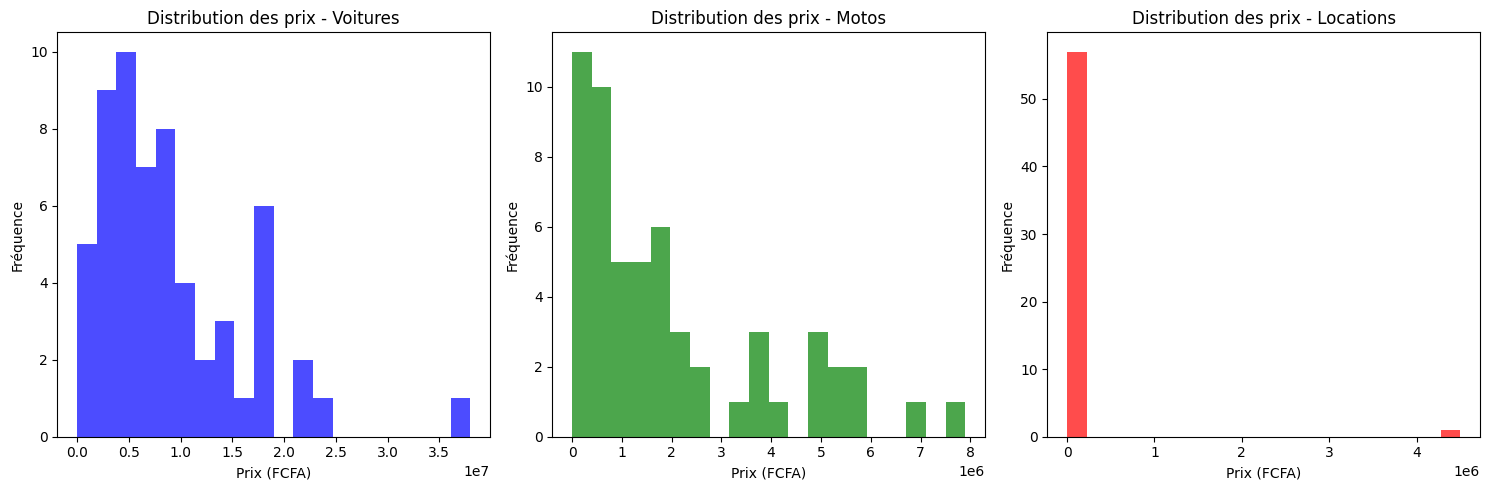

In [25]:
# Installer matplotlib si nécessaire
import matplotlib.pyplot as plt

# Distribution des prix par catégorie
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

if 'prix_numeric' in df_voitures.columns and not df_voitures['prix_numeric'].isna().all():
    axes[0].hist(df_voitures['prix_numeric'].dropna(), bins=20, color='blue', alpha=0.7)
    axes[0].set_title('Distribution des prix - Voitures')
    axes[0].set_xlabel('Prix (FCFA)')
    axes[0].set_ylabel('Fréquence')

if 'prix_numeric' in df_motos.columns and not df_motos['prix_numeric'].isna().all():
    axes[1].hist(df_motos['prix_numeric'].dropna(), bins=20, color='green', alpha=0.7)
    axes[1].set_title('Distribution des prix - Motos')
    axes[1].set_xlabel('Prix (FCFA)')
    axes[1].set_ylabel('Fréquence')

if 'prix_numeric' in df_locations.columns and not df_locations['prix_numeric'].isna().all():
    axes[2].hist(df_locations['prix_numeric'].dropna(), bins=20, color='red', alpha=0.7)
    axes[2].set_title('Distribution des prix - Locations')
    axes[2].set_xlabel('Prix (FCFA)')
    axes[2].set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig(f"{output_dir}/distribution_prix.png", dpi=300, bbox_inches='tight')
print(f"✓ Graphique sauvegardé: {output_dir}/distribution_prix.png")
plt.show()

---

## Instructions d'utilisation

### Étapes pour exécuter le scraping:

1. **Installer les dépendances** : Exécutez la cellule 2 pour installer les bibliothèques nécessaires
2. **Importer les bibliothèques** : Exécutez la cellule 3
3. **Charger les fonctions** : Exécutez toutes les cellules de fonctions (cellules 4-8)
4. **Lancer le scraping** : Exécutez la cellule 9 pour commencer le scraping
5. **Analyser les données** : Exécutez les cellules 10-11 pour voir les statistiques
6. **Sauvegarder les données** : Exécutez la cellule 12 pour exporter en CSV
7. **Visualiser (optionnel)** : Exécutez la cellule 13 pour générer des graphiques

### Notes importantes:

- Le scraping peut prendre plusieurs minutes selon le nombre de pages
- Les données sont sauvegardées dans le dossier `data_dakar_auto/`
- Vous pouvez ajuster `MAX_PAGES` dans la cellule d'exécution pour scraper plus ou moins de pages
- Le script inclut des pauses (1 seconde) entre chaque page pour respecter le serveur
- Les fonctions utilisent des sélecteurs génériques qui s'adaptent à la structure du site

### Fichiers générés:

- `voitures.csv` : Données des voitures
- `motos.csv` : Données des motos et scooters  
- `locations.csv` : Données des locations
- `toutes_annonces.csv` : Toutes les données combinées
- `distribution_prix.png` : Graphique de distribution des prix

---

# PARTIE 2: Scraping SANS nettoyage de TOUTES les pages

Cette section scrappe toutes les pages disponibles et conserve les données brutes sans nettoyage.

## Fonction de détection automatique du nombre de pages

In [ ]:
def get_total_pages(base_url: str) -> int:
    """Détecte automatiquement le nombre total de pages"""
    soup = get_page_content(base_url)
    if not soup:
        return 1
    
    try:
        # Chercher le lien "dernière page"
        pagination = soup.find('nav', class_='paginator')
        if pagination:
            last_page_link = pagination.find('a', string=lambda s: s and 'dernière page' in s.lower())
            if last_page_link and last_page_link.get('href'):
                # Extraire le numéro de page de l'URL
                match = re.search(r'page=(\d+)', last_page_link['href'])
                if match:
                    return int(match.group(1))
            
            # Si pas de lien "dernière page", chercher le plus grand numéro de page
            page_links = pagination.find_all('a', class_='page-link')
            max_page = 1
            for link in page_links:
                text = link.get_text().strip()
                if text.isdigit():
                    max_page = max(max_page, int(text))
            return max_page
    except Exception as e:
        print(f"Erreur lors de la détection du nombre de pages: {e}")
    
    return 1

## Fonctions de scraping SANS nettoyage - Toutes les pages

In [ ]:
def scrape_voitures_brut(base_url: str, max_pages: int = None) -> List[Dict]:
    """
    Scrape les données brutes des voitures (SANS NETTOYAGE) - TOUTES LES PAGES
    Variables: marque, année, prix, adresse, kilométrage, boite vitesse, carburant, propriétaire
    """
    # Détecter automatiquement le nombre de pages si non spécifié
    if max_pages is None:
        print("🔍 Détection du nombre total de pages...")
        max_pages = get_total_pages(base_url)
        print(f"✓ {max_pages} pages détectées\n")
    
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"📄 Scraping page {page}/{max_pages}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            print(f"❌ Impossible de récupérer la page {page}, arrêt.")
            break
            
        # Trouver tous les articles
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"⚠️ Aucun article trouvé sur la page {page}, arrêt.")
            break
            
        for article in articles:
            try:
                data = {}
                
                # V1: Marque - BRUT
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = title_link.get_text().strip() if title_link else title_elem.get_text().strip()
                else:
                    data['marque'] = ""
                
                # V2: Année
                data['année'] = ""
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # V3: Prix - BRUT
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = price_elem.get_text().strip() if price_elem else ""
                
                # V4: Adresse - BRUT
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(town_elem.get_text().strip())
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(province_elem.get_text().strip())
                data['adresse'] = ' '.join(address_parts)
                
                # V5, V6, V7: Caractéristiques - BRUT
                data['kilométrage'] = ""
                data['boite_vitesse'] = ""
                data['carburant'] = ""
                
                specs = article.find_all('li', class_='listing-card__attribute')
                for spec in specs:
                    spec_text = spec.get_text().strip()
                    spec_lower = spec_text.lower()
                    
                    if 'km' in spec_lower and not data['kilométrage']:
                        data['kilométrage'] = spec_text
                    
                    if 'automatique' in spec_lower or 'manuelle' in spec_lower:
                        data['boite_vitesse'] = spec_text
                    
                    if any(word in spec_lower for word in ['essence', 'diesel', 'hybride', 'électrique']):
                        data['carburant'] = spec_text
                
                # V8: Propriétaire - BRUT
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    data['propriétaire'] = author_link.get_text().strip() if author_link else author_elem.get_text().strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"⚠️ Erreur article: {e}")
                continue
        
        if page < max_pages:
            time.sleep(1)
    
    print(f"\n✅ Total voitures scrapées: {len(all_data)}")
    return all_data

In [ ]:
def scrape_motos_brut(base_url: str, max_pages: int = None) -> List[Dict]:
    """
    Scrape les données brutes des motos (SANS NETTOYAGE) - TOUTES LES PAGES
    Variables: marque, année, prix, adresse, kilométrage, propriétaire
    """
    if max_pages is None:
        print("🔍 Détection du nombre total de pages...")
        max_pages = get_total_pages(base_url)
        print(f"✓ {max_pages} pages détectées\n")
    
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"📄 Scraping page {page}/{max_pages}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            print(f"❌ Impossible de récupérer la page {page}, arrêt.")
            break
            
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"⚠️ Aucun article trouvé sur la page {page}, arrêt.")
            break
            
        for article in articles:
            try:
                data = {}
                
                # V1: Marque - BRUT
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = title_link.get_text().strip() if title_link else title_elem.get_text().strip()
                else:
                    data['marque'] = ""
                
                # V2: Année
                data['année'] = ""
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # V3: Prix - BRUT
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = price_elem.get_text().strip() if price_elem else ""
                
                # V4: Adresse - BRUT
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(town_elem.get_text().strip())
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(province_elem.get_text().strip())
                data['adresse'] = ' '.join(address_parts)
                
                # V5: Kilométrage - BRUT
                data['kilométrage'] = ""
                specs = article.find_all('li', class_='listing-card__attribute')
                for spec in specs:
                    spec_text = spec.get_text().strip()
                    if 'km' in spec_text.lower() and not data['kilométrage']:
                        data['kilométrage'] = spec_text
                        break
                
                # V6: Propriétaire - BRUT
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    data['propriétaire'] = author_link.get_text().strip() if author_link else author_elem.get_text().strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"⚠️ Erreur article: {e}")
                continue
        
        if page < max_pages:
            time.sleep(1)
    
    print(f"\n✅ Total motos scrapées: {len(all_data)}")
    return all_data

In [ ]:
def scrape_locations_brut(base_url: str, max_pages: int = None) -> List[Dict]:
    """
    Scrape les données brutes des locations (SANS NETTOYAGE) - TOUTES LES PAGES
    Variables: marque, année, prix, adresse, propriétaire
    """
    if max_pages is None:
        print("🔍 Détection du nombre total de pages...")
        max_pages = get_total_pages(base_url)
        print(f"✓ {max_pages} pages détectées\n")
    
    all_data = []
    
    for page in range(1, max_pages + 1):
        print(f"📄 Scraping page {page}/{max_pages}...")
        url = f"{base_url}?page={page}" if page > 1 else base_url
        soup = get_page_content(url)
        
        if not soup:
            print(f"❌ Impossible de récupérer la page {page}, arrêt.")
            break
            
        articles = soup.find_all('div', class_='listings-cards__list-item')
        
        if not articles:
            print(f"⚠️ Aucun article trouvé sur la page {page}, arrêt.")
            break
            
        for article in articles:
            try:
                data = {}
                
                # V1: Marque - BRUT
                title_elem = article.find('h2', class_='listing-card__header__title')
                if title_elem:
                    title_link = title_elem.find('a')
                    data['marque'] = title_link.get_text().strip() if title_link else title_elem.get_text().strip()
                else:
                    data['marque'] = ""
                
                # V2: Année
                data['année'] = ""
                if data['marque']:
                    year_match = re.search(r'\b(19|20)\d{2}\b', data['marque'])
                    if year_match:
                        data['année'] = year_match.group()
                
                # V3: Prix - BRUT
                price_elem = article.find('h3', class_='listing-card__header__price')
                data['prix'] = price_elem.get_text().strip() if price_elem else ""
                
                # V4: Adresse - BRUT
                address_parts = []
                town_elem = article.find('span', class_='town-suburb')
                if town_elem:
                    address_parts.append(town_elem.get_text().strip())
                province_elem = article.find('span', class_='province')
                if province_elem:
                    address_parts.append(province_elem.get_text().strip())
                data['adresse'] = ' '.join(address_parts)
                
                # V5: Propriétaire - BRUT
                author_elem = article.find('p', class_='time-author')
                if author_elem:
                    author_link = author_elem.find('a')
                    data['propriétaire'] = author_link.get_text().strip() if author_link else author_elem.get_text().strip()
                else:
                    data['propriétaire'] = ""
                
                all_data.append(data)
                
            except Exception as e:
                print(f"⚠️ Erreur article: {e}")
                continue
        
        if page < max_pages:
            time.sleep(1)
    
    print(f"\n✅ Total locations scrapées: {len(all_data)}")
    return all_data

## Exécution du scraping SANS nettoyage - TOUTES LES PAGES

In [ ]:
# URLs
URL_VOITURES = "https://www.dakar-auto.com/voitures-4"
URL_MOTOS = "https://www.dakar-auto.com/motos-and-scooters-3"
URL_LOCATIONS = "https://www.dakar-auto.com/location-de-voitures-19"

print("=" * 80)
print("🚗 SCRAPING DES VOITURES (TOUTES LES PAGES - SANS NETTOYAGE)")
print("=" * 80)
voitures_brutes = scrape_voitures_brut(URL_VOITURES)
df_voitures_brut = pd.DataFrame(voitures_brutes)

print("\n" + "=" * 80)
print("🏍️ SCRAPING DES MOTOS (TOUTES LES PAGES - SANS NETTOYAGE)")
print("=" * 80)
motos_brutes = scrape_motos_brut(URL_MOTOS)
df_motos_brut = pd.DataFrame(motos_brutes)

print("\n" + "=" * 80)
print("🚙 SCRAPING DES LOCATIONS (TOUTES LES PAGES - SANS NETTOYAGE)")
print("=" * 80)
locations_brutes = scrape_locations_brut(URL_LOCATIONS)
df_locations_brut = pd.DataFrame(locations_brutes)

print("\n" + "=" * 80)
print("✅ SCRAPING TERMINÉ!")
print("=" * 80)
print(f"Voitures: {len(df_voitures_brut)} lignes")
print(f"Motos: {len(df_motos_brut)} lignes")
print(f"Locations: {len(df_locations_brut)} lignes")

## Aperçu des données brutes

In [ ]:
print("🚗 VOITURES (données brutes):")
print(df_voitures_brut.head())
print(f"\nShape: {df_voitures_brut.shape}")
print(f"Valeurs manquantes:\n{df_voitures_brut.isnull().sum()}")

In [ ]:
print("🏍️ MOTOS (données brutes):")
print(df_motos_brut.head())
print(f"\nShape: {df_motos_brut.shape}")
print(f"Valeurs manquantes:\n{df_motos_brut.isnull().sum()}")

In [ ]:
print("🚙 LOCATIONS (données brutes):")
print(df_locations_brut.head())
print(f"\nShape: {df_locations_brut.shape}")
print(f"Valeurs manquantes:\n{df_locations_brut.isnull().sum()}")

## Sauvegarde des données brutes

In [ ]:
import os

# Créer le dossier pour les données brutes
output_dir = "data_dakar_auto_brutes"
os.makedirs(output_dir, exist_ok=True)

# Sauvegarder les données brutes en CSV
df_voitures_brut.to_csv(f"{output_dir}/voitures_brutes.csv", index=False, encoding='utf-8-sig')
df_motos_brut.to_csv(f"{output_dir}/motos_brutes.csv", index=False, encoding='utf-8-sig')
df_locations_brut.to_csv(f"{output_dir}/locations_brutes.csv", index=False, encoding='utf-8-sig')

print("✅ Données brutes sauvegardées dans le dossier:", output_dir)
print(f"   - voitures_brutes.csv ({len(df_voitures_brut)} lignes)")
print(f"   - motos_brutes.csv ({len(df_motos_brut)} lignes)")
print(f"   - locations_brutes.csv ({len(df_locations_brut)} lignes)")

---

## 📝 Résumé des deux approches

### PARTIE 1: Scraping avec nettoyage (pages limitées)
- ✅ Données nettoyées et formatées
- ✅ MAX_PAGES = 3 (pour tests rapides)
- ✅ Fonctions: `scrape_voitures()`, `scrape_motos()`, `scrape_locations()`
- ✅ Fonction de nettoyage: `clean_dataframe()`
- ✅ Output: dossier `data_dakar_auto/`

### PARTIE 2: Scraping sans nettoyage (toutes les pages)
- ✅ Données brutes (pas de nettoyage)
- ✅ TOUTES LES PAGES automatiquement détectées
- ✅ Fonctions: `scrape_voitures_brut()`, `scrape_motos_brut()`, `scrape_locations_brut()`
- ✅ Détection automatique: `get_total_pages()`
- ✅ Output: dossier `data_dakar_auto_brutes/`

**Usage recommandé:**
- PARTIE 1 pour tester et développer rapidement
- PARTIE 2 pour collecter l'ensemble complet des données